# Prepare dataset splits and metadata

In [2]:


import os
import shutil
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def compute_mask_area(mask_path):
    try:
        m = Image.open(mask_path).convert("L")
        arr = np.array(m)
        return int((arr > 127).sum())  # count white pixels as mask area
    except Exception:
        return 0

def gather_dataset(data_root):
    data_root = Path(data_root)
    classes = []
    images = []
    # Expect folders named "good" and "bad"
    for cls_name in ["good", "bad"]:
        cls_dir = data_root / cls_name
        if not cls_dir.exists():
            print(f" Warning: folder not found for class '{cls_name}' at {cls_dir}")
            continue
        for p in cls_dir.rglob("*"):
            if p.suffix.lower() in [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]:
                images.append(str(p.resolve()))
                classes.append(cls_name)
    # Masks (optional)
    masks_dir = data_root / "masks"
    mask_map = {}
    if masks_dir.exists():
        for p in masks_dir.rglob("*"):
            if p.suffix.lower() in [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]:
                mask_map[p.name] = str(p.resolve())
    return images, classes, mask_map

def build_metadata(images, classes, mask_map):
    rows = []
    for img_path, cls in tqdm(zip(images, classes), total=len(images), desc="Building metadata"):
        name = Path(img_path).name
        mask_path = mask_map.get(name, None)
        mask_area = compute_mask_area(mask_path) if mask_path else 0
        rows.append({
            "filename": name,
            "image_path": img_path,
            "class": cls,
            "mask_path": mask_path if mask_path else "",
            "mask_area": mask_area
        })
    df = pd.DataFrame(rows)
    return df

def create_splits(df, out_dir, test_size=0.10, val_size=0.10, seed=42):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Split into train, val, test
    train_val, test = train_test_split(df, test_size=test_size, stratify=df['class'], random_state=seed)
    rel_val = val_size / (1.0 - test_size)
    train, val = train_test_split(train_val, test_size=rel_val, stratify=train_val['class'], random_state=seed)

    print(f"Total: {len(df)}, Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

    # Create directories and copy files
    for split_name, split_df in [("train", train), ("val", val), ("test", test)]:
        split_dir = out_dir / split_name
        for cls in ["good", "bad"]:
            (split_dir / cls).mkdir(parents=True, exist_ok=True)
        for _, row in tqdm(split_df.iterrows(), total=len(split_df), desc=f"Copying {split_name}"):
            src = Path(row["image_path"])
            dst = split_dir / row["class"] / src.name
            if not dst.exists():
                shutil.copy(src, dst)
    # Save split CSVs
    train.to_csv(out_dir / "train_metadata.csv", index=False)
    val.to_csv(out_dir / "val_metadata.csv", index=False)
    test.to_csv(out_dir / "test_metadata.csv", index=False)
    df.to_csv(out_dir / "metadata_all.csv", index=False)
    print("\n Dataset preparation complete!")
    print(f"Splits saved in: {out_dir}")

# ---- Run the preparation ----

DATA_ROOT = "/kaggle/input/number-detection345/anomaly_detection_test_data"
OUTPUT_DIR = "./splits"

images, classes, mask_map = gather_dataset(DATA_ROOT)
df = build_metadata(images, classes, mask_map)
create_splits(df, OUTPUT_DIR, test_size=0.10, val_size=0.10, seed=42)


Building metadata: 100%|██████████| 5180/5180 [00:08<00:00, 607.59it/s]  


Total: 5180, Train: 4144, Val: 518, Test: 518


Copying test: 100%|██████████| 518/518 [00:04<00:00, 117.16it/s]


 Dataset preparation complete!
Splits saved in: splits


# Training setup for EfficientNet-B3

**Data Preprosessing**

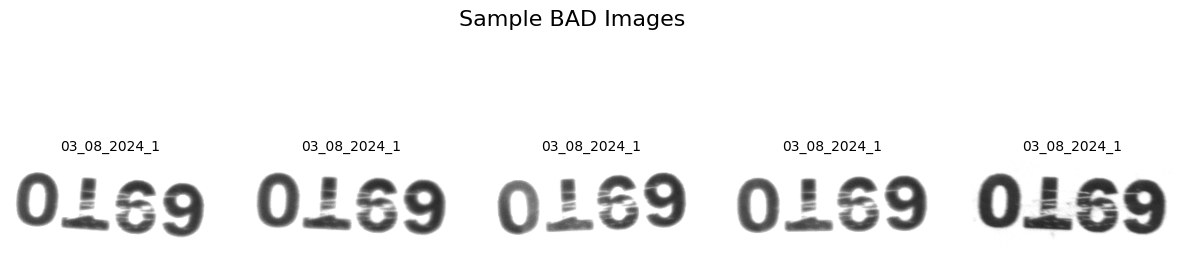

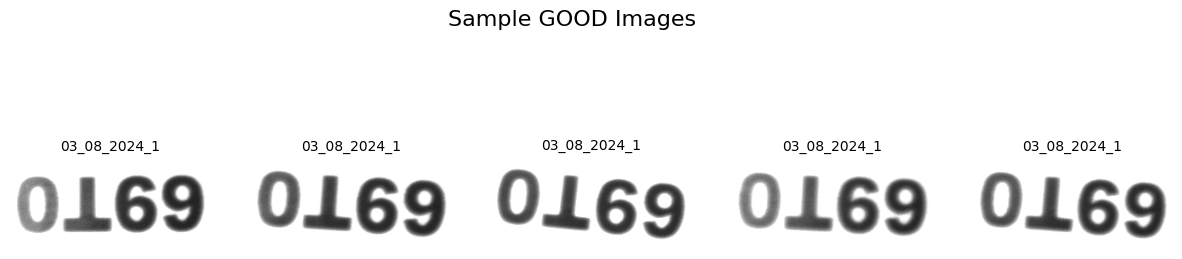

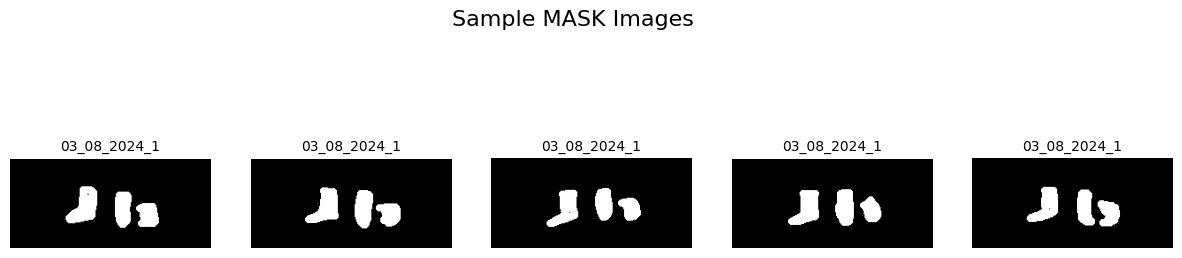

In [4]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths
bad_path = "/kaggle/input/number-detection345/anomaly_detection_test_data/bad"
good_path = "/kaggle/input/number-detection345/anomaly_detection_test_data/good"
mask_path = "/kaggle/input/number-detection345/anomaly_detection_test_data/masks"

def show_samples(folder, title, num_samples=5):
    files = sorted(os.listdir(folder))[:num_samples]

    plt.figure(figsize=(15, 4))
    plt.suptitle(title, fontsize=16)

    for i, file in enumerate(files):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(file[:12], fontsize=10)
        plt.axis("off")

    plt.show()


# Show samples
show_samples(bad_path, "Sample BAD Images")
show_samples(good_path, "Sample GOOD Images")
show_samples(mask_path, "Sample MASK Images")


In [3]:
# STEP 1: Count good and bad images in the training dataset

import os
from pathlib import Path

# Path to your split dataset
TRAIN_DIR = Path("/kaggle/working/splits/train")

# Count images in each class
def count_images_in_split(data_dir):
    counts = {}
    for cls_name in ["good", "bad"]:
        class_dir = data_dir / cls_name
        if class_dir.exists():
            counts[cls_name] = len(list(class_dir.glob("*.*")))
        else:
            counts[cls_name] = 0
    return counts

# Get counts
train_counts = count_images_in_split(TRAIN_DIR)

print(" Training Dataset Class Distribution:")
print(f"Good Images: {train_counts['good']}")
print(f"Bad Images:  {train_counts['bad']}")

# Optional: show imbalance ratio
if train_counts["bad"] > 0:
    ratio = train_counts["good"] / train_counts["bad"]
    print(f"\n  Imbalance Ratio (Good : Bad) = {ratio:.2f} : 1")
else:
    print("\n No bad images found!")


 Training Dataset Class Distribution:
Good Images: 3325
Bad Images:  819

  Imbalance Ratio (Good : Bad) = 4.06 : 1


**Data Balencing**

In [5]:
# STEP 1: Augment the "bad" class to balance it with "good"
# This will generate new images in /train/bad_aug/ and then merge them into /train/bad/

import os
import cv2
import random
import albumentations as A
from tqdm import tqdm
from pathlib import Path

# Paths
TRAIN_DIR = Path("/kaggle/working/splits/train")
GOOD_DIR = TRAIN_DIR / "good"
BAD_DIR = TRAIN_DIR / "bad"
AUG_BAD_DIR = TRAIN_DIR / "bad_aug"

# Create augmented folder if not exists
AUG_BAD_DIR.mkdir(parents=True, exist_ok=True)

# Count original samples
num_good = len(list(GOOD_DIR.glob("*.*")))
num_bad = len(list(BAD_DIR.glob("*.*")))

print(f"Original Counts → Good: {num_good}, Bad: {num_bad}")

# Calculate how many new bad images we need
needed_augmentations = num_good - num_bad
print(f" Need to generate approximately {needed_augmentations} new bad images...")

# Define augmentation pipeline for "bad" class
augment = A.Compose([
    A.OneOf([
        A.Rotate(limit=20, border_mode=cv2.BORDER_REFLECT),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, border_mode=cv2.BORDER_REFLECT),
    ], p=0.7),
    A.OneOf([
        A.HorizontalFlip(p=1),
        A.VerticalFlip(p=1),
        A.RandomRotate90(p=1),
    ], p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=1),
    ], p=0.7),
    A.OneOf([
        A.GaussNoise(var_limit=(10, 50), p=1),
        A.MotionBlur(blur_limit=3, p=1),
    ], p=0.5),
    A.Affine(shear=(-10, 10), translate_percent=(0.05, 0.05), p=0.5),
])

# Load all bad image paths
bad_images = list(BAD_DIR.glob("*.*"))

# Start augmentation
count_generated = 0
index = 0

print("\n Starting augmentation process...")
while count_generated < needed_augmentations:
    img_path = bad_images[index % len(bad_images)]
    img = cv2.imread(str(img_path))
    if img is None:
        index += 1
        continue

    # Apply augmentation
    augmented = augment(image=img)
    aug_img = augmented["image"]

    # Save augmented image
    out_path = AUG_BAD_DIR / f"{img_path.stem}_aug_{count_generated}.png"
    cv2.imwrite(str(out_path), aug_img)
    count_generated += 1
    index += 1

print(f"\n Generated {count_generated} new bad images at: {AUG_BAD_DIR}")

# Merge augmented images into main /bad/ folder for training
print("\n Merging augmented images into main /train/bad/...")
for aug_file in tqdm(list(AUG_BAD_DIR.glob("*.*"))):
    target_path = BAD_DIR / aug_file.name
    os.rename(aug_file, target_path)

# Clean up
AUG_BAD_DIR.rmdir()

# Final count check
final_bad_count = len(list(BAD_DIR.glob('*.*')))
print(f"\n Final count of bad images: {final_bad_count}")
print(f" Dataset balanced successfully! (Good: {num_good}, Bad: {final_bad_count})")


Original Counts → Good: 3325, Bad: 819
 Need to generate approximately 2506 new bad images...

 Starting augmentation process...


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_48/4164658484.py:46: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=1),



 Generated 2506 new bad images at: /kaggle/working/splits/train/bad_aug

 Merging augmented images into main /train/bad/...


100%|██████████| 2506/2506 [00:00<00:00, 39385.05it/s]


 Final count of bad images: 3325
 Dataset balanced successfully! (Good: 3325, Bad: 3325)


# EfficientNet Model training 

In [ ]:
# Train EfficientNet-B3 classifier 


!pip install timm torchmetrics --quiet

import os
import torch
import timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryF1Score
from tqdm import tqdm

# --------------------
# Configuration
# --------------------
DATA_DIR = "/kaggle/working/splits"  # your dataset path
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

BATCH_SIZE = 16
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------
# Data transforms
# --------------------
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --------------------
# Datasets and loaders
# --------------------
train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tfms)
val_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_ds.classes
print(" Classes detected:", class_names)

# --------------------
# Model definition
# --------------------
model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=1)
model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

precision_metric = BinaryPrecision(threshold=0.5).to(DEVICE)
recall_metric = BinaryRecall(threshold=0.5).to(DEVICE)
f1_metric = BinaryF1Score(threshold=0.5).to(DEVICE)

# --------------------
# Training & validation loop
# --------------------
best_val_f1 = 0

for epoch in range(NUM_EPOCHS):
    # ---- TRAIN ----
    model.train()
    train_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    # ---- VALIDATE ----
    model.eval()
    val_loss = 0
    preds_all, labels_all = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [val]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds_all.append(torch.sigmoid(outputs))
            labels_all.append(labels)
    preds_all = torch.cat(preds_all)
    labels_all = torch.cat(labels_all)

    val_precision = precision_metric(preds_all, labels_all)
    val_recall = recall_metric(preds_all, labels_all)
    val_f1 = f1_metric(preds_all, labels_all)
    avg_val_loss = val_loss / len(val_loader)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Precision (bad): {val_precision:.4f} | Recall (bad): {val_recall:.4f} | F1: {val_f1:.4f}")

    # ---- Save best model ----
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        save_path = os.path.join(MODEL_DIR, "efficientnet_b3_best.pt")
        torch.save(model.state_dict(), save_path)
        print(f" Saved new best model to {save_path}")

    scheduler.step(avg_val_loss)

print("\n Training complete! Best validation F1 (bad class):", best_val_f1.item())

# EfficientNet-B3 Model testing 

Model Loaded Successfully!


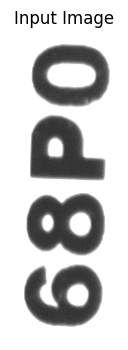


===== Corrected EfficientNet-B3 Prediction =====
Image Path         : /kaggle/working/splits/test/good/05_08_2024_10_46_13.752562_classifier_input.png
Probability GOOD   : 0.780401
Probability BAD    : 0.219599
Threshold (bad)    : 0.5
Predicted Class    : GOOD



('good', 0.21959900856018066)

In [8]:
!pip install timm==0.9.2 --quiet

import torch
import timm
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Configuration
# ---------------------------
MODEL_PATH = "/kaggle/input/classification-and-segmentation/pytorch/default/1/efficientnet_b3_best.pt"
IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CLASSIFIER_CONF_THRESHOLD = 0.50
CLASS_NAMES = ["good", "bad"]   # 0 = good, 1 = bad


# Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


# Load Model
def load_model(model_path):
    model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model


# Predict
def predict_single_image(image_path, model):

    img = Image.open(image_path).convert("RGB")

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(img_tensor)
        prob_good = torch.sigmoid(output).item()
        prob_bad = 1 - prob_good     # FIXED — correct probability

    predicted_label = 1 if prob_bad >= CLASSIFIER_CONF_THRESHOLD else 0
    predicted_class = CLASS_NAMES[predicted_label]

    print("\n===== Corrected EfficientNet-B3 Prediction =====")
    print(f"Image Path         : {image_path}")
    print(f"Probability GOOD   : {prob_good:.6f}")
    print(f"Probability BAD    : {prob_bad:.6f}")
    print(f"Threshold (bad)    : {CLASSIFIER_CONF_THRESHOLD}")
    print(f"Predicted Class    : {predicted_class.upper()}")
    print("=================================================\n")

    return predicted_class, prob_bad


# ---------------------------
# RUN
# ---------------------------

model = load_model(MODEL_PATH)
print("Model Loaded Successfully!")

test_image = "/kaggle/working/splits/test/good/05_08_2024_10_46_13.752562_classifier_input.png"
predict_single_image(test_image, model)


Model Loaded Successfully!


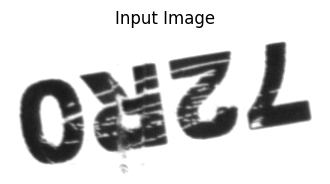


===== Corrected EfficientNet-B3 Prediction =====
Image Path         : /kaggle/working/splits/test/bad/09_08_2024_18_29_35.911078_classifier_input.png
Probability GOOD   : 0.000006
Probability BAD    : 0.999994
Threshold (bad)    : 0.5
Predicted Class    : BAD



('bad', 0.9999936518966024)

In [6]:
!pip install timm==0.9.2 --quiet

import torch
import timm
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Configuration
# ---------------------------
MODEL_PATH = "/kaggle/input/classification-and-segmentation/pytorch/default/1/efficientnet_b3_best.pt"
IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CLASSIFIER_CONF_THRESHOLD = 0.50
CLASS_NAMES = ["good", "bad"]   # 0 = good, 1 = bad


# Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


# Load Model
def load_model(model_path):
    model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model


# Predict
def predict_single_image(image_path, model):

    img = Image.open(image_path).convert("RGB")

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(img_tensor)
        prob_good = torch.sigmoid(output).item()
        prob_bad = 1 - prob_good     # FIXED — correct probability

    predicted_label = 1 if prob_bad >= CLASSIFIER_CONF_THRESHOLD else 0
    predicted_class = CLASS_NAMES[predicted_label]

    print("\n===== Corrected EfficientNet-B3 Prediction =====")
    print(f"Image Path         : {image_path}")
    print(f"Probability GOOD   : {prob_good:.6f}")
    print(f"Probability BAD    : {prob_bad:.6f}")
    print(f"Threshold (bad)    : {CLASSIFIER_CONF_THRESHOLD}")
    print(f"Predicted Class    : {predicted_class.upper()}")
    print("=================================================\n")

    return predicted_class, prob_bad


# ---------------------------
# RUN
# ---------------------------

model = load_model(MODEL_PATH)
print("Model Loaded Successfully!")

test_image = "/kaggle/working/splits/test/bad/09_08_2024_18_29_35.911078_classifier_input.png"
predict_single_image(test_image, model)


Test classes: ['bad', 'good']

 Test Results:
Loss: 0.1448
Precision (bad): 0.9974
Recall (bad): 0.9279
F1 Score (bad): 0.9614


<Figure size 500x400 with 0 Axes>

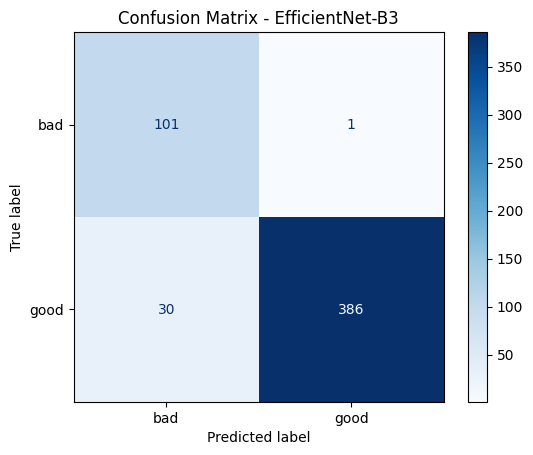

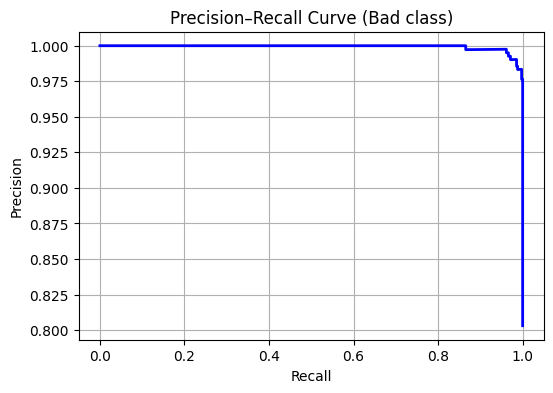


Confusion Matrix Details:
True Positives (TP): 386
False Positives (FP): 1
False Negatives (FN): 30
True Negatives (TN): 101

 Evaluation Complete!


In [19]:
#Evaluate EfficientNet-B3 classifier on confusion matrix ,precision, recall and 

!pip install timm torchmetrics scikit-learn matplotlib --quiet

import os
import torch
import timm
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# --------------------
# Configuration
# --------------------
DATA_DIR = "/kaggle/working/splits/test"
MODEL_PATH = "/kaggle/input/classification-and-segmentation/pytorch/default/1/efficientnet_b3_best.pt"
IMG_SIZE = 224
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------
# Data setup
# --------------------
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

test_ds = datasets.ImageFolder(DATA_DIR, transform=test_tfms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
class_names = test_ds.classes
print("Test classes:", class_names)

# --------------------
# Load model
# --------------------
model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

criterion = nn.BCEWithLogitsLoss()
precision_metric = BinaryPrecision(threshold=0.5).to(DEVICE)
recall_metric = BinaryRecall(threshold=0.5).to(DEVICE)
f1_metric = BinaryF1Score(threshold=0.5).to(DEVICE)

# --------------------
# Evaluation loop
# --------------------
preds_all, labels_all = [], []
test_loss = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds_all.append(torch.sigmoid(outputs))
        labels_all.append(labels)

preds_all = torch.cat(preds_all)
labels_all = torch.cat(labels_all)
avg_test_loss = test_loss / len(test_loader)

precision = precision_metric(preds_all, labels_all)
recall = recall_metric(preds_all, labels_all)
f1 = f1_metric(preds_all, labels_all)

print(f"\n Test Results:")
print(f"Loss: {avg_test_loss:.4f}")
print(f"Precision (bad): {precision:.4f}")
print(f"Recall (bad): {recall:.4f}")
print(f"F1 Score (bad): {f1:.4f}")

# --------------------
# Confusion Matrix
# --------------------
y_true = labels_all.cpu().numpy().astype(int)
y_pred = (preds_all.cpu().numpy() > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - EfficientNet-B3")
plt.show()

# --------------------
# Precision–Recall Curve
# --------------------
y_score = preds_all.cpu().numpy()
precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_score)

plt.figure(figsize=(6, 4))
plt.plot(recall_curve, precision_curve, color="blue", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Bad class)")
plt.grid(True)
plt.show()

# --------------------
# Class-level Summary
# --------------------
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]

print("\nConfusion Matrix Details:")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")

print("\n Evaluation Complete!")

# FineTuning of EfficientNet-B3 

In [ ]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm

# ------------------------------------------------
# CONFIG
# ------------------------------------------------
TRAIN_DIR = "/kaggle/working/splits/train"
VAL_DIR   = "/kaggle/working/splits/val"
MODEL_PATH = "/kaggle/input/classification-and-segmentation/pytorch/default/1/efficientnet_b3_best.pt"

IMG_SIZE = 224
BATCH_SIZE = 16
LR = 1e-5               # smaller LR for stable fine-tuning
EPOCHS = 10

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ------------------------------------------------
# TRANSFORMS
# ------------------------------------------------
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2,0.2),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# ------------------------------------------------
# DATA LOADERS
# ------------------------------------------------
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))

# ------------------------------------------------
# LOAD MODEL
# ------------------------------------------------
model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# ------------------------------------------------
# VALIDATION FUNCTION
# ------------------------------------------------
def evaluate_validation():
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs)
            preds_all.append(probs.cpu())
            labels_all.append(labels.cpu())

    preds_all = torch.cat(preds_all).numpy()
    labels_all = torch.cat(labels_all).numpy()
    preds_bin = (preds_all > 0.5).astype(int)

    precision = precision_score(labels_all, preds_bin)
    recall    = recall_score(labels_all, preds_bin)
    f1        = f1_score(labels_all, preds_bin)
    acc       = accuracy_score(labels_all, preds_bin)

    return precision, recall, f1, acc

# ------------------------------------------------
# TRAIN FOR EXTRA EPOCHS
# ------------------------------------------------
best_f1 = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        imgs = imgs.to(DEVICE)
        labels = labels.float().unsqueeze(1).to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    precision, recall, f1, acc = evaluate_validation()

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Loss      : {avg_loss:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"Accuracy  : {acc:.4f}")

    # save best model
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "/kaggle/working/efficientnet_b3_finetuned.pt")
        print("Saved BEST model")

print("\nTraining finished!")
print("Best model saved at: /kaggle/working/efficientnet_b3_finetuned.pt")

# EfficientNet-B3 Finetuned Model testing 

Model Loaded Successfully!


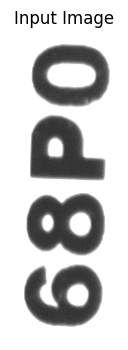


===== Corrected EfficientNet-B3 Prediction =====
Image Path         : /kaggle/working/splits/test/good/05_08_2024_10_46_13.752562_classifier_input.png
Probability GOOD   : 0.989505
Probability BAD    : 0.010495
Threshold (bad)    : 0.5
Predicted Class    : GOOD



('good', 0.010495424270629883)

In [15]:
!pip install timm==0.9.2 --quiet

import torch
import timm
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Configuration
# ---------------------------
MODEL_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/efficientnet_b3_finetuned_final.pt"
IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CLASSIFIER_CONF_THRESHOLD = 0.50
CLASS_NAMES = ["good", "bad"]   # 0 = good, 1 = bad


# Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


# Load Model
def load_model(model_path):
    model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model


# Predict
def predict_single_image(image_path, model):

    img = Image.open(image_path).convert("RGB")

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(img_tensor)
        prob_good = torch.sigmoid(output).item()
        prob_bad = 1 - prob_good     # FIXED — correct probability

    predicted_label = 1 if prob_bad >= CLASSIFIER_CONF_THRESHOLD else 0
    predicted_class = CLASS_NAMES[predicted_label]

    print("\n===== Corrected EfficientNet-B3 Prediction =====")
    print(f"Image Path         : {image_path}")
    print(f"Probability GOOD   : {prob_good:.6f}")
    print(f"Probability BAD    : {prob_bad:.6f}")
    print(f"Threshold (bad)    : {CLASSIFIER_CONF_THRESHOLD}")
    print(f"Predicted Class    : {predicted_class.upper()}")
    print("=================================================\n")

    return predicted_class, prob_bad


# ---------------------------
# RUN
# ---------------------------

model = load_model(MODEL_PATH)
print("Model Loaded Successfully!")

test_image = "/kaggle/working/splits/test/good/05_08_2024_10_46_13.752562_classifier_input.png"
predict_single_image(test_image, model)


Model Loaded Successfully!


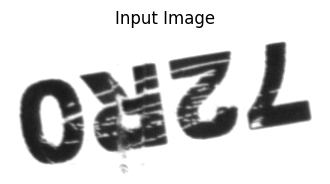


===== Corrected EfficientNet-B3 Prediction =====
Image Path         : /kaggle/working/splits/test/bad/09_08_2024_18_29_35.911078_classifier_input.png
Probability GOOD   : 0.000000
Probability BAD    : 1.000000
Threshold (bad)    : 0.5
Predicted Class    : BAD



('bad', 0.9999999289549351)

In [16]:
!pip install timm==0.9.2 --quiet

import torch
import timm
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Configuration
# ---------------------------
MODEL_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/efficientnet_b3_finetuned_final.pt"
IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CLASSIFIER_CONF_THRESHOLD = 0.50
CLASS_NAMES = ["good", "bad"]   # 0 = good, 1 = bad


# Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


# Load Model
def load_model(model_path):
    model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model


# Predict
def predict_single_image(image_path, model):

    img = Image.open(image_path).convert("RGB")

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(img_tensor)
        prob_good = torch.sigmoid(output).item()
        prob_bad = 1 - prob_good     # FIXED — correct probability

    predicted_label = 1 if prob_bad >= CLASSIFIER_CONF_THRESHOLD else 0
    predicted_class = CLASS_NAMES[predicted_label]

    print("\n===== Corrected EfficientNet-B3 Prediction =====")
    print(f"Image Path         : {image_path}")
    print(f"Probability GOOD   : {prob_good:.6f}")
    print(f"Probability BAD    : {prob_bad:.6f}")
    print(f"Threshold (bad)    : {CLASSIFIER_CONF_THRESHOLD}")
    print(f"Predicted Class    : {predicted_class.upper()}")
    print("=================================================\n")

    return predicted_class, prob_bad


# ---------------------------
# RUN
# ---------------------------

model = load_model(MODEL_PATH)
print("Model Loaded Successfully!")

test_image = "/kaggle/working/splits/test/bad/09_08_2024_18_29_35.911078_classifier_input.png"
predict_single_image(test_image, model)


Test classes: ['bad', 'good']

 Test Results:
Loss: 0.0563
Precision (bad): 1.0000
Recall (bad): 0.9976
F1 Score (bad): 0.9988


<Figure size 500x400 with 0 Axes>

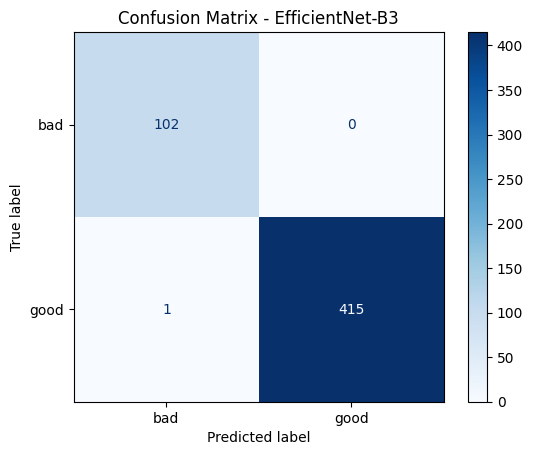

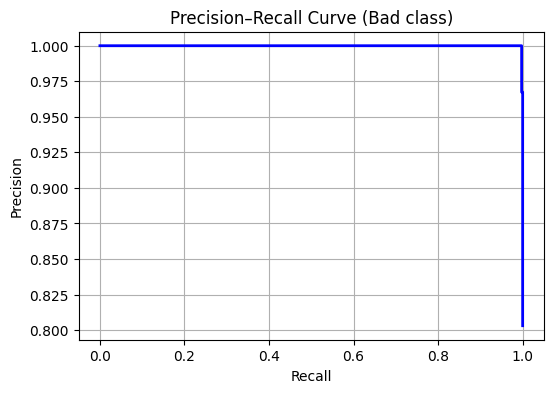


Confusion Matrix Details:
True Positives (TP): 415
False Positives (FP): 0
False Negatives (FN): 1
True Negatives (TN): 102

 Evaluation Complete!


In [18]:
#Evaluate EfficientNet-B3 classifier on confusion matrix ,precision, recall and 

!pip install timm torchmetrics scikit-learn matplotlib --quiet

import os
import torch
import timm
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# --------------------
# Configuration
# --------------------
DATA_DIR = "/kaggle/working/splits/test"
MODEL_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/efficientnet_b3_finetuned_final.pt"
IMG_SIZE = 224
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------
# Data setup
# --------------------
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

test_ds = datasets.ImageFolder(DATA_DIR, transform=test_tfms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
class_names = test_ds.classes
print("Test classes:", class_names)

# --------------------
# Load model
# --------------------
model = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

criterion = nn.BCEWithLogitsLoss()
precision_metric = BinaryPrecision(threshold=0.5).to(DEVICE)
recall_metric = BinaryRecall(threshold=0.5).to(DEVICE)
f1_metric = BinaryF1Score(threshold=0.5).to(DEVICE)

# --------------------
# Evaluation loop
# --------------------
preds_all, labels_all = [], []
test_loss = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds_all.append(torch.sigmoid(outputs))
        labels_all.append(labels)

preds_all = torch.cat(preds_all)
labels_all = torch.cat(labels_all)
avg_test_loss = test_loss / len(test_loader)

precision = precision_metric(preds_all, labels_all)
recall = recall_metric(preds_all, labels_all)
f1 = f1_metric(preds_all, labels_all)

print(f"\n Test Results:")
print(f"Loss: {avg_test_loss:.4f}")
print(f"Precision (bad): {precision:.4f}")
print(f"Recall (bad): {recall:.4f}")
print(f"F1 Score (bad): {f1:.4f}")

# --------------------
# Confusion Matrix
# --------------------
y_true = labels_all.cpu().numpy().astype(int)
y_pred = (preds_all.cpu().numpy() > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - EfficientNet-B3")
plt.show()

# --------------------
# Precision–Recall Curve
# --------------------
y_score = preds_all.cpu().numpy()
precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_score)

plt.figure(figsize=(6, 4))
plt.plot(recall_curve, precision_curve, color="blue", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Bad class)")
plt.grid(True)
plt.show()

# --------------------
# Class-level Summary
# --------------------
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]

print("\nConfusion Matrix Details:")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")

print("\n Evaluation Complete!")

# Segmentation Model training setup

In [21]:
import cv2
import numpy as np
from pathlib import Path

# ---- Correct dataset paths ----
BAD_IMG_DIR = Path("/kaggle/input/number-detection345/anomaly_detection_test_data/bad")
BAD_MASK_DIR = Path("/kaggle/input/number-detection345/anomaly_detection_test_data/masks")
# -------------------------------

bad_img_count = len(list(BAD_IMG_DIR.glob("*.*")))
bad_mask_count = 0
zero_masks = 0
non_zero_masks = 0

for mask_path in BAD_MASK_DIR.glob("*.*"):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue

    bad_mask_count += 1
    if np.sum(mask) == 0:
        zero_masks += 1
    else:
        non_zero_masks += 1

print("Total BAD images:", bad_img_count)
print("Total BAD masks:", bad_mask_count)

Total BAD images: 1023
Total BAD masks: 1023


In [24]:
import cv2
import numpy as np
from pathlib import Path

GOOD_IMG_DIR = Path("/kaggle/input/number-detection345/anomaly_detection_test_data/good")
GOOD_MASK_DIR = Path("/kaggle/working/splits/train_masks/good")

# Make output folder
GOOD_MASK_DIR.mkdir(parents=True, exist_ok=True)

# Load ALL good images
good_images = sorted(list(GOOD_IMG_DIR.glob("*.*")))

# Select only first 1023 (balanced with BAD images)
good_images = good_images[:1023]

print("Selected good images:", len(good_images))

# Create zero masks for these
for img_path in good_images:
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]
    
    zero_mask = np.zeros((h, w), dtype=np.uint8)
    
    out_path = GOOD_MASK_DIR / f"{img_path.stem}_mask.png"
    cv2.imwrite(str(out_path), zero_mask)

print(" Done! Zero masks created for 1023 GOOD images.")

Selected good images: 1023
 Done! Zero masks created for 1023 GOOD images.


# U-Net++ segmentation Model training 

In [ ]:

import os
import cv2
import torch
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# ------------------------------------------------
# CONFIG
# ------------------------------------------------
IMG_H = 256
IMG_W = 256
BATCH_SIZE = 4
EPOCHS = 30
LR = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ------------------------------------------------
# PATHS
# ------------------------------------------------
BAD_IMG_DIR  = Path("/kaggle/input/number-detection345/anomaly_detection_test_data/bad")
BAD_MASK_DIR = Path("/kaggle/input/number-detection345/anomaly_detection_test_data/masks")

GOOD_IMG_DIR = Path("/kaggle/working/splits/train/good")   # 3325 good images


# ------------------------------------------------
# 1. LOAD BAD images + masks
# ------------------------------------------------
def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp")
    return sorted([p for p in Path(folder).glob("*") if p.suffix.lower() in exts])

bad_imgs  = list_images(BAD_IMG_DIR)
bad_masks = list_images(BAD_MASK_DIR)

assert len(bad_imgs) == len(bad_masks), "Bad images and masks count mismatch!"

print("BAD images :", len(bad_imgs))   # 1023
print("BAD masks  :", len(bad_masks))  # 1023


# ------------------------------------------------
# 2. SELECT EXACTLY 1023 GOOD IMAGES
# ------------------------------------------------
good_imgs_all = list_images(GOOD_IMG_DIR)
print("GOOD images available:", len(good_imgs_all))

# Only take the first 1023
good_imgs = good_imgs_all[:len(bad_imgs)]

print("GOOD images selected:", len(good_imgs))  # should be 1023

# No good masks on disk → will generate zero mask dynamically


# ------------------------------------------------
# 3. Build mask dictionary for BAD images
# ------------------------------------------------
mask_dict = {p.name: p for p in bad_masks}


# ------------------------------------------------
# 4. Dataset Class
# ------------------------------------------------
class ScratchDataset(Dataset):
    def __init__(self, good_imgs, bad_imgs, mask_dict, transform=None):
        self.good_imgs = good_imgs
        self.bad_imgs = bad_imgs
        self.mask_dict = mask_dict
        self.transform = transform

        # Final balanced dataset of 2046 samples
        self.all_imgs = self.good_imgs + self.bad_imgs

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):

        img_path = self.all_imgs[idx]
        name = img_path.name

        # load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # If mask exists → BAD image
        if name in self.mask_dict:
            mask_path = self.mask_dict[name]
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            mask = (mask > 127).astype("float32")
        else:
            # Good image → ZERO mask (same H×W)
            mask = np.zeros((img.shape[0], img.shape[1]), dtype="float32")

        # Apply transforms
        if self.transform:
            t = self.transform(image=img, mask=mask)
            img = t["image"]
            mask = t["mask"]

        mask = mask.unsqueeze(0).float()
        return img, mask


# ------------------------------------------------
# 5. Transforms
# ------------------------------------------------
train_tf = A.Compose([
    A.Resize(IMG_H, IMG_W),
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.95,1.05), rotate=(-6,6), translate_percent=(0.02,0.02), p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406),
                std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# ------------------------------------------------
# 6. Dataloader
# ------------------------------------------------
dataset = ScratchDataset(good_imgs, bad_imgs, mask_dict, transform=train_tf)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("Total training samples:", len(dataset))  # must be 2046
print("Batches:", len(train_loader))


# ------------------------------------------------
# 7. Model
# ------------------------------------------------
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
).to(DEVICE)

dice = smp.losses.DiceLoss(mode="binary")
bce  = torch.nn.BCEWithLogitsLoss()

def loss_fn(pred, mask):
    return dice(pred, mask) + bce(pred, mask)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


# ------------------------------------------------
# 8. Training Loop
# ------------------------------------------------
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}/{EPOCHS} — Avg Loss: {total_loss / len(train_loader):.4f}")


# ------------------------------------------------
# 9. Save model
# ------------------------------------------------
SAVE_PATH = "/kaggle/working/unetpp_balanced1023_trained.pth"
torch.save(model.state_dict(), SAVE_PATH)

print("Saved model:", SAVE_PATH)

# U-Net++ MOdel Testing 

In [ ]:
!pip install --no-cache-dir segmentation-models-pytorch


Image: 09_08_2024_18_29_35.911078_classifier_input.png
Scratch area ratio: 0.157776
User threshold: 0.005
Final Decision: BAD


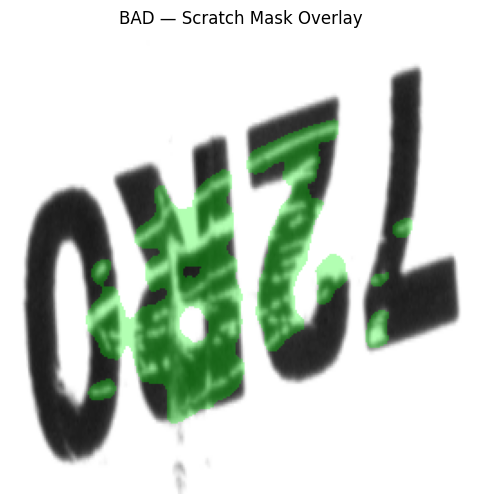

In [30]:

import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
import albumentations as A
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------
MODEL_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/u-net_final.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = (256, 256)

# User threshold: percentage of image area that must be scratch

USER_THRESHOLD = 0.005000


# --------------------------------------------------------------
# LOAD MODEL
# --------------------------------------------------------------
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
).to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()


# --------------------------------------------------------------
# PREPROCESS PIPELINE
# --------------------------------------------------------------
test_tf = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=(0.485,0.456,0.406),
                std=(0.229,0.224,0.225)),
    ToTensorV2(),
])


# --------------------------------------------------------------
# PREDICTION FUNCTION
# --------------------------------------------------------------
def predict_single_image(image_path, user_threshold=USER_THRESHOLD, show=True):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError("Image not found: " + image_path)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Preprocess
    t = test_tf(image=img_rgb)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(model(x))

    mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    area_ratio = mask.sum() / mask.size

    # Decision
    if area_ratio > user_threshold:
        decision = "bad"
    else:
        decision = "good"

    print("Image:", Path(image_path).name)
    print("Scratch area ratio:", round(area_ratio, 6))
    print("User threshold:", user_threshold)
    print("Final Decision:", decision.upper())

    # If GOOD → return directly
    if decision == "good":
        print("No segmentation overlay shown for GOOD images.")
        return decision, area_ratio, None

    # If BAD → create overlay
    img_vis = cv2.resize(img_rgb, IMG_SIZE)
    overlay = img_vis.copy()
    overlay[mask == 1] = (0, 255, 0)  # highlight scratches

    blended = cv2.addWeighted(img_vis, 0.7, overlay, 0.3, 0)

    # show
    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(blended)
        plt.axis("off")
        plt.title("BAD — Scratch Mask Overlay")
        plt.show()

    return decision, area_ratio, blended


# --------------------------------------------------------------
# EXAMPLE USAGE
# --------------------------------------------------------------
# Replace this with your test image
TEST_IMAGE = "/kaggle/working/splits/test/bad/09_08_2024_18_29_35.911078_classifier_input.png"

decision, area_ratio, overlay = predict_single_image(TEST_IMAGE)

In [31]:

import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
import albumentations as A
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------
MODEL_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/u-net_final.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = (256, 256)

# User threshold: percentage of image area that must be scratch

USER_THRESHOLD = 0.005000


# --------------------------------------------------------------
# LOAD MODEL
# --------------------------------------------------------------
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
).to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()


# --------------------------------------------------------------
# PREPROCESS PIPELINE
# --------------------------------------------------------------
test_tf = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=(0.485,0.456,0.406),
                std=(0.229,0.224,0.225)),
    ToTensorV2(),
])


# --------------------------------------------------------------
# PREDICTION FUNCTION
# --------------------------------------------------------------
def predict_single_image(image_path, user_threshold=USER_THRESHOLD, show=True):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError("Image not found: " + image_path)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Preprocess
    t = test_tf(image=img_rgb)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(model(x))

    mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    area_ratio = mask.sum() / mask.size

    # Decision
    if area_ratio > user_threshold:
        decision = "bad"
    else:
        decision = "good"

    print("Image:", Path(image_path).name)
    print("Scratch area ratio:", round(area_ratio, 6))
    print("User threshold:", user_threshold)
    print("Final Decision:", decision.upper())

    # If GOOD → return directly
    if decision == "good":
        print("No segmentation overlay shown for GOOD images.")
        return decision, area_ratio, None

    # If BAD → create overlay
    img_vis = cv2.resize(img_rgb, IMG_SIZE)
    overlay = img_vis.copy()
    overlay[mask == 1] = (0, 255, 0)  # highlight scratches

    blended = cv2.addWeighted(img_vis, 0.7, overlay, 0.3, 0)

    # show
    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(blended)
        plt.axis("off")
        plt.title("BAD — Scratch Mask Overlay")
        plt.show()

    return decision, area_ratio, blended


# --------------------------------------------------------------
# EXAMPLE USAGE
# --------------------------------------------------------------
# Replace this with your test image
TEST_IMAGE = "/kaggle/working/splits/test/good/05_08_2024_11_40_49.818787_classifier_input.png"

decision, area_ratio, overlay = predict_single_image(TEST_IMAGE)

Image: 05_08_2024_11_40_49.818787_classifier_input.png
Scratch area ratio: 0.0
User threshold: 0.005
Final Decision: GOOD
No segmentation overlay shown for GOOD images.


Evaluating good: 416 images


100%|██████████| 416/416 [00:09<00:00, 42.23it/s]


Evaluating bad: 102 images


100%|██████████| 102/102 [00:02<00:00, 43.31it/s]



Saved: unetpp_batch_results.csv

=== FINAL METRICS ===
Accuracy : 0.9749
Precision: 0.8938
Recall   : 0.9902
F1 Score : 0.9395


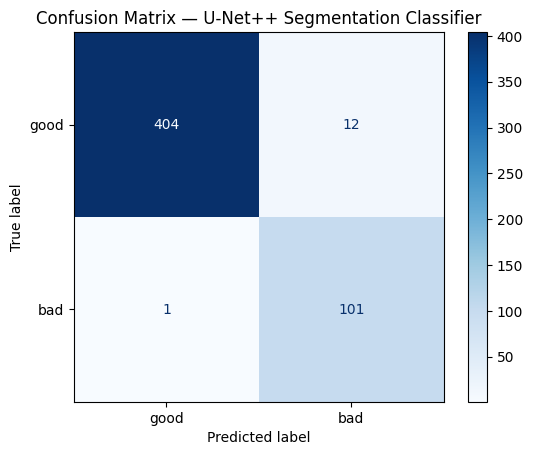

In [32]:
# ==============================================================
#               U-Net++ BATCH EVALUATION 
# ==============================================================

import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tqdm import tqdm


# --------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------
MODEL_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/u-net_final.pth"
TEST_ROOT = Path("/kaggle/working/splits/test")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = (256, 256)

USER_THRESHOLD = 0.004   # SAME AS SINGLE-IMAGE TESTING


# --------------------------------------------------------------
# LOAD MODEL
# --------------------------------------------------------------
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
).to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()


# --------------------------------------------------------------
# TRANSFORM
# --------------------------------------------------------------
test_tf = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=(0.485,0.456,0.406),
                std=(0.229,0.224,0.225)),
    ToTensorV2(),
])


# --------------------------------------------------------------
# FUNCTION — Predict only by segmentation
# --------------------------------------------------------------
def predict_mask(path, user_threshold):
    img_rgb = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    t = test_tf(image=img_rgb)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(model(x))

    mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    area_ratio = mask.sum() / mask.size

    final_pred = 1 if area_ratio > user_threshold else 0   # 1 = BAD, 0 = GOOD

    return final_pred, area_ratio


# --------------------------------------------------------------
# BATCH EVALUATION
# --------------------------------------------------------------
results = []

y_true = []
y_pred = []

for cls in ["good", "bad"]:
    folder = TEST_ROOT / cls
    paths = sorted(list(folder.glob("*.*")))

    print(f"Evaluating {cls}: {len(paths)} images")

    for img_path in tqdm(paths):
        pred, area_ratio = predict_mask(img_path, USER_THRESHOLD)

        true_label = 0 if cls == "good" else 1

        results.append({
            "image": img_path.name,
            "true_label": true_label,
            "pred_label": pred,
            "area_ratio": area_ratio
        })

        y_true.append(true_label)
        y_pred.append(pred)


# SAVE RESULTS
df = pd.DataFrame(results)
df.to_csv("unetpp_batch_results.csv", index=False)
print("\nSaved: unetpp_batch_results.csv")


# --------------------------------------------------------------
# METRICS
# --------------------------------------------------------------
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print("\n=== FINAL METRICS ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")


# --------------------------------------------------------------
# CONFUSION MATRIX
# --------------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["good", "bad"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — U-Net++ Segmentation Classifier")
plt.show()

# Hybrid Model Intergreation Using EfficientNet-B3 and U-Net++ 

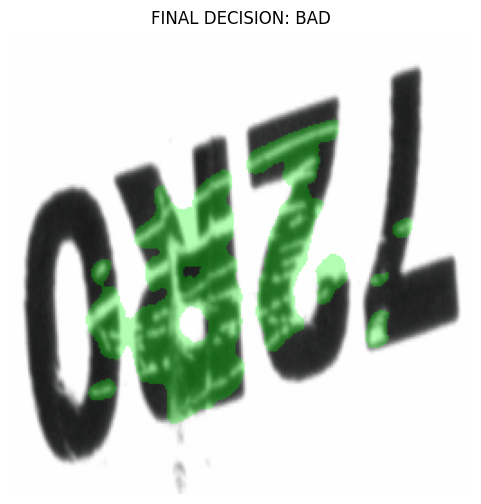


========== FINAL INFERENCE RESULT ==========
Image                  : /kaggle/working/splits/test/bad/09_08_2024_18_29_35.911078_classifier_input.png
Classifier Label       : GOOD
Classifier Conf (bad)  : 0.000004
Seg. Area Ratio        : 0.157776
Seg Decision (> 0.001) : True
---------------------------------------------
FINAL DECISION         : BAD



'bad'

In [43]:
# -------------------------------
# Single Image Evaluation - One Image Output (Overlay Only)
# -------------------------------

import torch
import timm
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

MODEL_CLS_PATH = "/kaggle/input/classification-and-segmentation/pytorch/default/1/efficientnet_b3_best.pt"
MODEL_SEG_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/u-net_final.pth"

IMG_SIZE_CLS = 224
IMG_SIZE_SEG = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

USER_THRESHOLD = 0.001
CLASSIFIER_CONF_THRESHOLD = 0.99

cls_tf = A.Compose([
    A.Resize(IMG_SIZE_CLS, IMG_SIZE_CLS),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

seg_tf = A.Compose([
    A.Resize(IMG_SIZE_SEG, IMG_SIZE_SEG),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# Load classifier
classifier = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
classifier.load_state_dict(torch.load(MODEL_CLS_PATH, map_location=DEVICE))
classifier = classifier.to(DEVICE).eval()

# Load segmentation model
segmenter = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)
segmenter.load_state_dict(torch.load(MODEL_SEG_PATH, map_location=DEVICE))
segmenter = segmenter.to(DEVICE).eval()


def predict_classifier(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = cls_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        raw = classifier(x)
        prob_good = torch.sigmoid(raw).item()

    prob_bad = 1 - prob_good
    label = 1 if prob_bad >= CLASSIFIER_CONF_THRESHOLD else 0
    return label, prob_bad


def segment_scratches(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = seg_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(segmenter(x))

    mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    area_ratio = mask.sum() / mask.size

    img_vis = (t["image"].cpu().permute(1,2,0).numpy() *
               np.array([0.229,0.224,0.225]) +
               np.array([0.485,0.456,0.406]))
    img_vis = np.clip(img_vis * 255, 0, 255).astype(np.uint8)

    # Overlay mask in green
    overlay = img_vis.copy()
    overlay[mask == 1] = (0, 255, 0)
    vis = cv2.addWeighted(img_vis, 0.7, overlay, 0.3, 0)

    return mask, area_ratio, vis


def classify_single_image(image_path):

    cls_label, cls_conf = predict_classifier(image_path)
    mask, area_ratio, overlay = segment_scratches(image_path)

    seg_decision = area_ratio > USER_THRESHOLD

    # Hybrid logic
    if cls_label == 1 and seg_decision:
        final = 1
    elif cls_label == 1 and cls_conf < CLASSIFIER_CONF_THRESHOLD:
        final = 1
    elif cls_label == 1 and (not seg_decision) and cls_conf >= CLASSIFIER_CONF_THRESHOLD:
        final = 0
    elif cls_label == 0 and seg_decision:
        final = 1
    else:
        final = 0

    final_cls = "bad" if final == 1 else "good"

    # ---- SHOW ONLY ONE OUTPUT IMAGE ----
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"FINAL DECISION: {final_cls.upper()}")
    plt.show()

    # ---- PRINT RESULT ----
    print("\n========== FINAL INFERENCE RESULT ==========")
    print(f"Image                  : {image_path}")
    print(f"Classifier Label       : {'BAD' if cls_label==1 else 'GOOD'}")
    print(f"Classifier Conf (bad)  : {cls_conf:.6f}")
    print(f"Seg. Area Ratio        : {area_ratio:.6f}")
    print(f"Seg Decision (> {USER_THRESHOLD}) : {seg_decision}")
    print("---------------------------------------------")
    print(f"FINAL DECISION         : {final_cls.upper()}")
    print("=============================================\n")

    return final_cls


# ---------------- RUN TEST ----------------
test_image = "/kaggle/working/splits/test/bad/09_08_2024_18_29_35.911078_classifier_input.png"
classify_single_image(test_image)


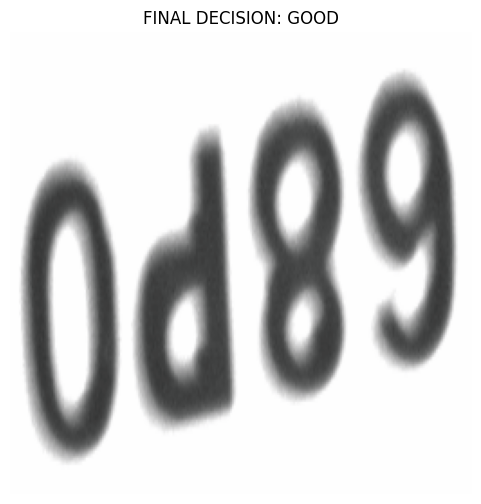


========== FINAL INFERENCE RESULT ==========
Image                  : /kaggle/working/splits/test/good/05_08_2024_11_40_49.818787_classifier_input.png
Classifier Label       : GOOD
Classifier Conf (bad)  : 0.443447
Seg. Area Ratio        : 0.000000
Seg Decision (> 0.001) : False
---------------------------------------------
FINAL DECISION         : GOOD



'good'

In [47]:
# -------------------------------
# Single Image Evaluation - One Image Output (Overlay Only)
# -------------------------------

import torch
import timm
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

MODEL_CLS_PATH = "/kaggle/input/classification-and-segmentation/pytorch/default/1/efficientnet_b3_best.pt"
MODEL_SEG_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/u-net_final.pth"

IMG_SIZE_CLS = 224
IMG_SIZE_SEG = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

USER_THRESHOLD = 0.001
CLASSIFIER_CONF_THRESHOLD = 0.99

cls_tf = A.Compose([
    A.Resize(IMG_SIZE_CLS, IMG_SIZE_CLS),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

seg_tf = A.Compose([
    A.Resize(IMG_SIZE_SEG, IMG_SIZE_SEG),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# Load classifier
classifier = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
classifier.load_state_dict(torch.load(MODEL_CLS_PATH, map_location=DEVICE))
classifier = classifier.to(DEVICE).eval()

# Load segmentation model
segmenter = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)
segmenter.load_state_dict(torch.load(MODEL_SEG_PATH, map_location=DEVICE))
segmenter = segmenter.to(DEVICE).eval()


def predict_classifier(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = cls_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        raw = classifier(x)
        prob_good = torch.sigmoid(raw).item()

    prob_bad = 1 - prob_good
    label = 1 if prob_bad >= CLASSIFIER_CONF_THRESHOLD else 0
    return label, prob_bad


def segment_scratches(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = seg_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(segmenter(x))

    mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    area_ratio = mask.sum() / mask.size

    img_vis = (t["image"].cpu().permute(1,2,0).numpy() *
               np.array([0.229,0.224,0.225]) +
               np.array([0.485,0.456,0.406]))
    img_vis = np.clip(img_vis * 255, 0, 255).astype(np.uint8)

    # Overlay mask in green
    overlay = img_vis.copy()
    overlay[mask == 1] = (0, 255, 0)
    vis = cv2.addWeighted(img_vis, 0.7, overlay, 0.3, 0)

    return mask, area_ratio, vis


def classify_single_image(image_path):

    cls_label, cls_conf = predict_classifier(image_path)
    mask, area_ratio, overlay = segment_scratches(image_path)

    seg_decision = area_ratio > USER_THRESHOLD

    # Hybrid logic
    if cls_label == 1 and seg_decision:
        final = 1
    elif cls_label == 1 and cls_conf < CLASSIFIER_CONF_THRESHOLD:
        final = 1
    elif cls_label == 1 and (not seg_decision) and cls_conf >= CLASSIFIER_CONF_THRESHOLD:
        final = 0
    elif cls_label == 0 and seg_decision:
        final = 1
    else:
        final = 0

    final_cls = "bad" if final == 1 else "good"

    # ---- SHOW ONLY ONE OUTPUT IMAGE ----
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"FINAL DECISION: {final_cls.upper()}")
    plt.show()

    # ---- PRINT RESULT ----
    print("\n========== FINAL INFERENCE RESULT ==========")
    print(f"Image                  : {image_path}")
    print(f"Classifier Label       : {'BAD' if cls_label==1 else 'GOOD'}")
    print(f"Classifier Conf (bad)  : {cls_conf:.6f}")
    print(f"Seg. Area Ratio        : {area_ratio:.6f}")
    print(f"Seg Decision (> {USER_THRESHOLD}) : {seg_decision}")
    print("---------------------------------------------")
    print(f"FINAL DECISION         : {final_cls.upper()}")
    print("=============================================\n")

    return final_cls


# ---------------- RUN TEST ----------------
test_image = "/kaggle/working/splits/test/good/05_08_2024_11_40_49.818787_classifier_input.png"
classify_single_image(test_image)


Evaluating bad: 100%|██████████| 102/102 [00:04<00:00, 22.13it/s]



Saved detailed results to batch_results.csv

Evaluation Summary:
Precision: 0.8947
Recall:    0.3333
F1 Score:  0.4857
Accuracy:  0.8610


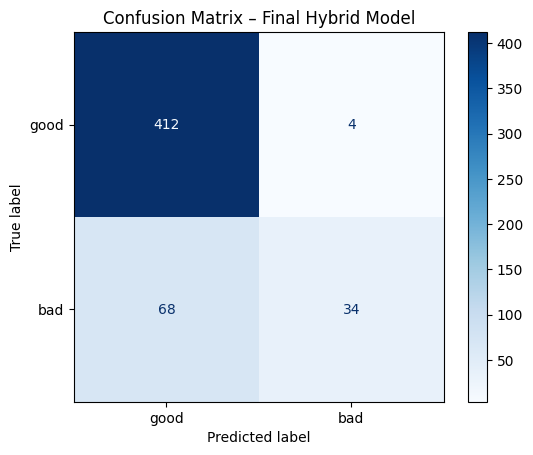


Batch evaluation complete!


In [44]:
# STEP 7 — Batch Evaluation for Precision, Recall, F1, Accuracy

import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path


# Default threshold values 
USER_THRESHOLD = 0.001			               
CLASSIFIER_CONF_THRESHOLD = 0.99  

TEST_ROOT = Path("/kaggle/working/splits/test")

# -------------------------------------------------------
# Batch evaluation
# -------------------------------------------------------
def evaluate_batch(test_root=TEST_ROOT, user_threshold=USER_THRESHOLD, conf_thresh=CLASSIFIER_CONF_THRESHOLD):
    results = []
    all_y_true, all_y_pred = [], []

    for cls_name in ["good", "bad"]:
        class_dir = test_root / cls_name
        if not class_dir.exists():
            continue

        for img_path in tqdm(list(class_dir.glob("*.*")), desc=f"Evaluating {cls_name}"):

            try:
                cls_label, cls_conf = predict_classifier(str(img_path))
                mask, area_ratio, _ = segment_scratches(str(img_path))

                seg_decision = area_ratio > user_threshold

                # ---------------- HYBRID DECISION LOGIC  ----------------
                if cls_label == 1 and seg_decision:
                    final_pred = 1
                elif cls_label == 1 and cls_conf < conf_thresh:
                    final_pred = 1
                elif cls_label == 1 and not seg_decision and cls_conf >= conf_thresh:
                    final_pred = 0
                else:
                    final_pred = 0
                # ---------------------------------------------------------

                results.append({
                    "image": img_path.name,
                    "true_label": 1 if cls_name == "bad" else 0,
                    "pred_label": final_pred,
                    "classifier_label": cls_label,
                    "classifier_conf": cls_conf,
                    "seg_area_ratio": area_ratio
                })

                all_y_true.append(1 if cls_name == "bad" else 0)
                all_y_pred.append(final_pred)

            except Exception as e:
                print(f"Error on {img_path.name}: {e}")

    # Save results
    df = pd.DataFrame(results)
    df.to_csv("batch_results.csv", index=False)
    print("\nSaved detailed results to batch_results.csv")

    # ---------------- METRICS ----------------
    precision = precision_score(all_y_true, all_y_pred)
    recall    = recall_score(all_y_true, all_y_pred)
    f1        = f1_score(all_y_true, all_y_pred)
    acc       = accuracy_score(all_y_true, all_y_pred)

    print("\nEvaluation Summary:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Accuracy:  {acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_y_true, all_y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["good", "bad"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix – Final Hybrid Model")
    plt.show()

    return df, precision, recall, f1, acc

# -------------------------------------------------------
# RUN EVALUATION
# -------------------------------------------------------
df_eval, prec, rec, f1s, acc = evaluate_batch()

print("\nBatch evaluation complete!")

# Finding the Best Threshold value Using the Grid Search 

In [45]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

TEST_ROOT = Path("/kaggle/working/splits/test")

cache = []   # will store results of classifier + segmenter

print("Caching classifier + segmentation outputs...")

test_items = []
for cls_name in ["good", "bad"]:
    class_dir = TEST_ROOT / cls_name
    if not class_dir.exists(): continue

    for p in class_dir.glob("*.*"):
        test_items.append((str(p), 1 if cls_name == "bad" else 0))

for img_path, true_label in tqdm(test_items):

    cls_label, cls_conf = predict_classifier(img_path)
    _, area_ratio, _ = segment_scratches(img_path)

    cache.append({
        "img": img_path,
        "true": true_label,
        "cls_label": cls_label,
        "cls_conf": cls_conf,
        "area_ratio": area_ratio
    })

df_cache = pd.DataFrame(cache)
df_cache.to_csv("cached_model_outputs.csv", index=False)
print("Cached results saved → cached_model_outputs.csv")

Caching classifier + segmentation outputs...


100%|██████████| 518/518 [00:23<00:00, 22.16it/s]

Cached results saved → cached_model_outputs.csv


In [46]:
# Load cached results
df = pd.read_csv("cached_model_outputs.csv")

user_thresh_list = np.linspace(0.0001, 0.005, 20)
conf_thresh_list = np.linspace(0.50, 0.99, 20)

results = []

print("Running FAST threshold grid search...")

for user_t in tqdm(user_thresh_list, desc="USER_THRESH"):
    for conf_t in conf_thresh_list:

        y_true = []
        y_pred = []

        for _, row in df.iterrows():

            cls_label = row["cls_label"]
            cls_conf  = row["cls_conf"]
            seg_area  = row["area_ratio"]
            true_lab  = row["true"]

            seg_decision = seg_area > user_t

            # -------------------------------------------------
            # Correct Step-6 Hybrid Logic (with confidence)
            # -------------------------------------------------
            if cls_label == 1 and seg_decision:
                final = 1
            elif cls_label == 1 and cls_conf < conf_t:
                final = 1
            elif cls_label == 1 and (not seg_decision) and cls_conf >= conf_t:
                final = 0
            elif cls_label == 0 and seg_decision:
                final = 1
            else:
                final = 0
            # -------------------------------------------------

            y_true.append(true_lab)
            y_pred.append(final)

        # compute metrics
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        acc  = accuracy_score(y_true, y_pred)

        results.append({
            "user_threshold": float(user_t),
            "conf_threshold": float(conf_t),
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "accuracy": acc
        })

df_res = pd.DataFrame(results)
df_res.to_csv("threshold_grid_results_fast.csv", index=False)
print("Saved → threshold_grid_results_fast.csv")

Running FAST threshold grid search...


USER_THRESH: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]

Saved → threshold_grid_results_fast.csv


In [48]:
df = pd.read_csv("threshold_grid_results_fast.csv")

print("\nTOP 10 by PRECISION:")
display(df.sort_values("precision", ascending=False).head(10))

print("\nCandidates with precision between 0.80 and 0.90:")
candidates = df[(df["precision"] >= 0.80) & (df["precision"] <= 0.90)]
display(candidates.sort_values("precision", ascending=False).head(20))


TOP 10 by PRECISION:


,user_threshold,conf_threshold,precision,recall,f1,accuracy
399,0.005,0.990000,0.906542,0.95098,0.92823,0.971042
398,0.005,0.964211,0.906542,0.95098,0.92823,0.971042
397,0.005,0.938421,0.906542,0.95098,0.92823,0.971042
396,0.005,0.912632,0.906542,0.95098,0.92823,0.971042
395,0.005,0.886842,0.906542,0.95098,0.92823,0.971042
394,0.005,0.861053,0.906542,0.95098,0.92823,0.971042
393,0.005,0.835263,0.906542,0.95098,0.92823,0.971042
380,0.005,0.500000,0.906542,0.95098,0.92823,0.971042
381,0.005,0.525789,0.906542,0.95098,0.92823,0.971042
382,0.005,0.551579,0.906542,0.95098,0.92823,0.971042



Candidates with precision between 0.80 and 0.90:


,user_threshold,conf_threshold,precision,recall,f1,accuracy
342,0.004484,0.551579,0.899083,0.960784,0.92891,0.971042
343,0.004484,0.577368,0.899083,0.960784,0.92891,0.971042
344,0.004484,0.603158,0.899083,0.960784,0.92891,0.971042
345,0.004484,0.628947,0.899083,0.960784,0.92891,0.971042
346,0.004484,0.654737,0.899083,0.960784,0.92891,0.971042
347,0.004484,0.680526,0.899083,0.960784,0.92891,0.971042
348,0.004484,0.706316,0.899083,0.960784,0.92891,0.971042
349,0.004484,0.732105,0.899083,0.960784,0.92891,0.971042
341,0.004484,0.525789,0.899083,0.960784,0.92891,0.971042
340,0.004484,0.500000,0.899083,0.960784,0.92891,0.971042


# Hybrid Model Testing Using the Best Threshold value 

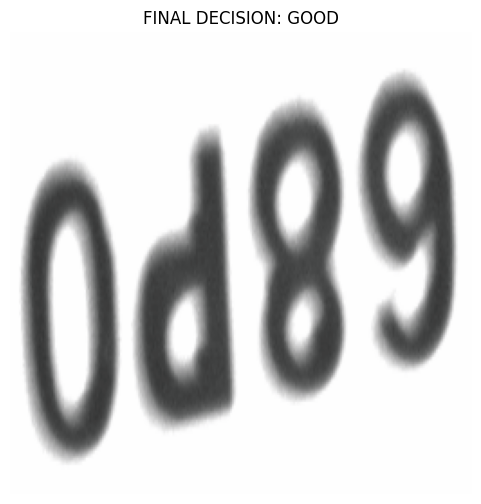


========== FINAL INFERENCE RESULT ==========
Image                  : /kaggle/working/splits/test/good/05_08_2024_11_40_49.818787_classifier_input.png
Classifier Label       : GOOD
Classifier Conf (bad)  : 0.443447
Seg. Area Ratio        : 0.000000
Seg Decision (> 0.004484) : False
---------------------------------------------
FINAL DECISION         : GOOD



'good'

In [52]:
# -------------------------------
# Single Image Evaluation - One Image Output (Overlay Only)
# -------------------------------

import torch
import timm
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

MODEL_CLS_PATH = "/kaggle/input/classification-and-segmentation/pytorch/default/1/efficientnet_b3_best.pt"
MODEL_SEG_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/u-net_final.pth"

IMG_SIZE_CLS = 224
IMG_SIZE_SEG = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

USER_THRESHOLD = 0.004484	
CLASSIFIER_CONF_THRESHOLD =0.551579

cls_tf = A.Compose([
    A.Resize(IMG_SIZE_CLS, IMG_SIZE_CLS),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

seg_tf = A.Compose([
    A.Resize(IMG_SIZE_SEG, IMG_SIZE_SEG),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# Load classifier
classifier = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
classifier.load_state_dict(torch.load(MODEL_CLS_PATH, map_location=DEVICE))
classifier = classifier.to(DEVICE).eval()

# Load segmentation model
segmenter = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)
segmenter.load_state_dict(torch.load(MODEL_SEG_PATH, map_location=DEVICE))
segmenter = segmenter.to(DEVICE).eval()


def predict_classifier(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = cls_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        raw = classifier(x)
        prob_good = torch.sigmoid(raw).item()

    prob_bad = 1 - prob_good
    label = 1 if prob_bad >= CLASSIFIER_CONF_THRESHOLD else 0
    return label, prob_bad


def segment_scratches(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = seg_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(segmenter(x))

    mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    area_ratio = mask.sum() / mask.size

    img_vis = (t["image"].cpu().permute(1,2,0).numpy() *
               np.array([0.229,0.224,0.225]) +
               np.array([0.485,0.456,0.406]))
    img_vis = np.clip(img_vis * 255, 0, 255).astype(np.uint8)

    # Overlay mask in green
    overlay = img_vis.copy()
    overlay[mask == 1] = (0, 255, 0)
    vis = cv2.addWeighted(img_vis, 0.7, overlay, 0.3, 0)

    return mask, area_ratio, vis


def classify_single_image(image_path):

    cls_label, cls_conf = predict_classifier(image_path)
    mask, area_ratio, overlay = segment_scratches(image_path)

    seg_decision = area_ratio > USER_THRESHOLD

    # Hybrid logic
    if cls_label == 1 and seg_decision:
        final = 1
    elif cls_label == 1 and cls_conf < CLASSIFIER_CONF_THRESHOLD:
        final = 1
    elif cls_label == 1 and (not seg_decision) and cls_conf >= CLASSIFIER_CONF_THRESHOLD:
        final = 0
    elif cls_label == 0 and seg_decision:
        final = 1
    else:
        final = 0

    final_cls = "bad" if final == 1 else "good"

    # ---- SHOW ONLY ONE OUTPUT IMAGE ----
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"FINAL DECISION: {final_cls.upper()}")
    plt.show()

    # ---- PRINT RESULT ----
    print("\n========== FINAL INFERENCE RESULT ==========")
    print(f"Image                  : {image_path}")
    print(f"Classifier Label       : {'BAD' if cls_label==1 else 'GOOD'}")
    print(f"Classifier Conf (bad)  : {cls_conf:.6f}")
    print(f"Seg. Area Ratio        : {area_ratio:.6f}")
    print(f"Seg Decision (> {USER_THRESHOLD}) : {seg_decision}")
    print("---------------------------------------------")
    print(f"FINAL DECISION         : {final_cls.upper()}")
    print("=============================================\n")

    return final_cls


# ---------------- RUN TEST ----------------
test_image = "/kaggle/working/splits/test/good/05_08_2024_11_40_49.818787_classifier_input.png"
classify_single_image(test_image)


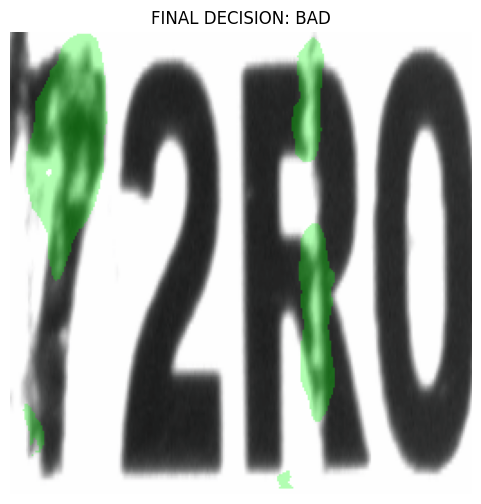


========== FINAL INFERENCE RESULT ==========
Image                  : /kaggle/working/splits/test/bad/09_08_2024_18_11_44.808143_classifier_input.png
Classifier Label       : GOOD
Classifier Conf (bad)  : 0.004934
Seg. Area Ratio        : 0.103394
Seg Decision (> 0.004484) : True
---------------------------------------------
FINAL DECISION         : BAD



'bad'

In [53]:
# -------------------------------
# Single Image Evaluation - One Image Output (Overlay Only)
# -------------------------------

import torch
import timm
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

MODEL_CLS_PATH = "/kaggle/input/classification-and-segmentation/pytorch/default/1/efficientnet_b3_best.pt"
MODEL_SEG_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/u-net_final.pth"

IMG_SIZE_CLS = 224
IMG_SIZE_SEG = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

USER_THRESHOLD = 0.004484	
CLASSIFIER_CONF_THRESHOLD =0.551579

cls_tf = A.Compose([
    A.Resize(IMG_SIZE_CLS, IMG_SIZE_CLS),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

seg_tf = A.Compose([
    A.Resize(IMG_SIZE_SEG, IMG_SIZE_SEG),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# Load classifier
classifier = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
classifier.load_state_dict(torch.load(MODEL_CLS_PATH, map_location=DEVICE))
classifier = classifier.to(DEVICE).eval()

# Load segmentation model
segmenter = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)
segmenter.load_state_dict(torch.load(MODEL_SEG_PATH, map_location=DEVICE))
segmenter = segmenter.to(DEVICE).eval()


def predict_classifier(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = cls_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        raw = classifier(x)
        prob_good = torch.sigmoid(raw).item()

    prob_bad = 1 - prob_good
    label = 1 if prob_bad >= CLASSIFIER_CONF_THRESHOLD else 0
    return label, prob_bad


def segment_scratches(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = seg_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(segmenter(x))

    mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    area_ratio = mask.sum() / mask.size

    img_vis = (t["image"].cpu().permute(1,2,0).numpy() *
               np.array([0.229,0.224,0.225]) +
               np.array([0.485,0.456,0.406]))
    img_vis = np.clip(img_vis * 255, 0, 255).astype(np.uint8)

    # Overlay mask in green
    overlay = img_vis.copy()
    overlay[mask == 1] = (0, 255, 0)
    vis = cv2.addWeighted(img_vis, 0.7, overlay, 0.3, 0)

    return mask, area_ratio, vis


def classify_single_image(image_path):

    cls_label, cls_conf = predict_classifier(image_path)
    mask, area_ratio, overlay = segment_scratches(image_path)

    seg_decision = area_ratio > USER_THRESHOLD

    # Hybrid logic
    if cls_label == 1 and seg_decision:
        final = 1
    elif cls_label == 1 and cls_conf < CLASSIFIER_CONF_THRESHOLD:
        final = 1
    elif cls_label == 1 and (not seg_decision) and cls_conf >= CLASSIFIER_CONF_THRESHOLD:
        final = 0
    elif cls_label == 0 and seg_decision:
        final = 1
    else:
        final = 0

    final_cls = "bad" if final == 1 else "good"

    # ---- SHOW ONLY ONE OUTPUT IMAGE ----
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"FINAL DECISION: {final_cls.upper()}")
    plt.show()

    # ---- PRINT RESULT ----
    print("\n========== FINAL INFERENCE RESULT ==========")
    print(f"Image                  : {image_path}")
    print(f"Classifier Label       : {'BAD' if cls_label==1 else 'GOOD'}")
    print(f"Classifier Conf (bad)  : {cls_conf:.6f}")
    print(f"Seg. Area Ratio        : {area_ratio:.6f}")
    print(f"Seg Decision (> {USER_THRESHOLD}) : {seg_decision}")
    print("---------------------------------------------")
    print(f"FINAL DECISION         : {final_cls.upper()}")
    print("=============================================\n")

    return final_cls


# ---------------- RUN TEST ----------------
test_image = "/kaggle/working/splits/test/bad/09_08_2024_18_11_44.808143_classifier_input.png"
classify_single_image(test_image)



Starting batch evaluation...



Evaluating bad: 100%|██████████| 102/102 [00:04<00:00, 22.38it/s]



Saved detailed results → batch_results.csv

===== Evaluation Summary =====
Precision : 0.9018
Recall    : 0.9902
F1 Score  : 0.9439
Accuracy  : 0.9768


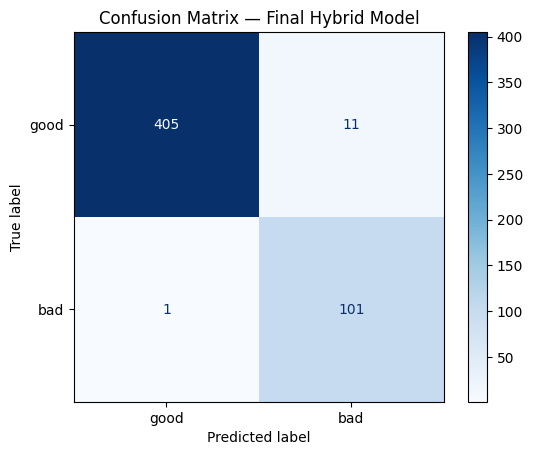


Batch evaluation complete!


In [55]:

import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
#  FINAL OPTIMAL THRESHOLDS FOUND VIA GRID SEARCH
# ------------------------------------------------------------
USER_THRESHOLD = 0.004226           # segmentation threshold
CLASSIFIER_CONF_THRESHOLD = 0.50    # classifier trust threshold

# Test dataset root
TEST_ROOT = Path("/kaggle/working/splits/test")

# ------------------------------------------------------------
#  Batch evaluation function
# ------------------------------------------------------------
def evaluate_batch(
        test_root=TEST_ROOT, 
        user_threshold=USER_THRESHOLD, 
        conf_thresh=CLASSIFIER_CONF_THRESHOLD
    ):
    
    results = []
    all_y_true, all_y_pred = [], []

    print("\nStarting batch evaluation...\n")

    # Loop over GOOD and BAD folders
    for cls_name in ["good", "bad"]:
        class_dir = test_root / cls_name
        if not class_dir.exists():
            continue

        for img_path in tqdm(list(class_dir.glob("*.*")), desc=f"Evaluating {cls_name}"):

            try:
                # --- Step 1: Classifier ---
                cls_label, cls_conf = predict_classifier(str(img_path))
                
                # --- Step 2: Segmentation ---
                mask, area_ratio, _ = segment_scratches(str(img_path))

                seg_decision = area_ratio > user_threshold

                # -------------------------------------------------------
                # FINAL HYBRID DECISION LOGIC (Correct + Clean Version)
                # -------------------------------------------------------
                if cls_label == 1 and seg_decision:
                    final_pred = 1   # classifier bad + segmentation bad
                elif cls_label == 1 and cls_conf < conf_thresh:
                    final_pred = 1   # classifier uncertain → treat as bad
                elif cls_label == 1 and (not seg_decision) and cls_conf >= conf_thresh:
                    final_pred = 0   # classifier confident + no scratch
                elif cls_label == 0 and seg_decision:
                    final_pred = 1   # segmentation detected scratch
                else:
                    final_pred = 0   # everything indicates good
                # -------------------------------------------------------

                true_val = 1 if cls_name == "bad" else 0

                results.append({
                    "image": img_path.name,
                    "true_label": true_val,
                    "pred_label": final_pred,
                    "classifier_label": cls_label,
                    "classifier_conf": cls_conf,
                    "seg_area_ratio": area_ratio
                })

                all_y_true.append(true_val)
                all_y_pred.append(final_pred)

            except Exception as e:
                print(f"Error on {img_path.name}: {e}")

    # ------------------------------------------------------------
    # Save CSV output
    # ------------------------------------------------------------
    df = pd.DataFrame(results)
    df.to_csv("batch_results.csv", index=False)
    print("\nSaved detailed results → batch_results.csv")

    # ------------------------------------------------------------
    # Compute metrics
    # ------------------------------------------------------------
    precision = precision_score(all_y_true, all_y_pred)
    recall    = recall_score(all_y_true, all_y_pred)
    f1        = f1_score(all_y_true, all_y_pred)
    acc       = accuracy_score(all_y_true, all_y_pred)

    print("\n===== Evaluation Summary =====")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"Accuracy  : {acc:.4f}")

    # ------------------------------------------------------------
    # Confusion Matrix
    # ------------------------------------------------------------
    cm = confusion_matrix(all_y_true, all_y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["good", "bad"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix — Final Hybrid Model")
    plt.show()

    return df, precision, recall, f1, acc


# ------------------------------------------------------------
#   RUN EVALUATION
# ------------------------------------------------------------
df_eval, prec, rec, f1s, acc = evaluate_batch()
print("\nBatch evaluation complete!")

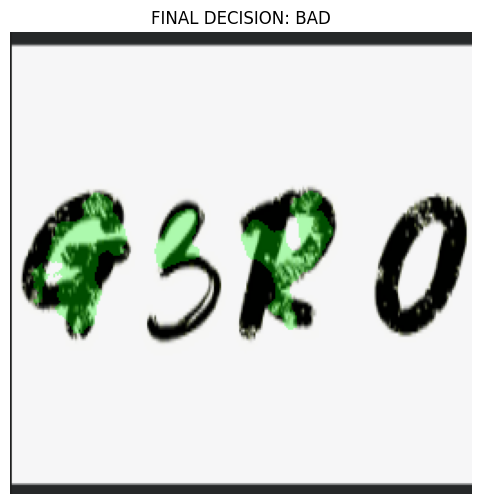


========== FINAL INFERENCE RESULT ==========
Image                  : /kaggle/input/real-world-data/Screenshot 2025-11-15 160511.png
Classifier Label       : GOOD
Classifier Conf (bad)  : 0.000066
Seg. Area Ratio        : 0.062332
Seg Decision (> 0.004484) : True
---------------------------------------------
FINAL DECISION         : BAD



'bad'

In [59]:
# -------------------------------
# Single Image Evaluation - One Image Output (Overlay Only)
# -------------------------------

import torch
import timm
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

MODEL_CLS_PATH = "/kaggle/input/classification-and-segmentation/pytorch/default/1/efficientnet_b3_best.pt"
MODEL_SEG_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/u-net_final.pth"

IMG_SIZE_CLS = 224
IMG_SIZE_SEG = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

USER_THRESHOLD = 0.004484	
CLASSIFIER_CONF_THRESHOLD =0.551579

cls_tf = A.Compose([
    A.Resize(IMG_SIZE_CLS, IMG_SIZE_CLS),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

seg_tf = A.Compose([
    A.Resize(IMG_SIZE_SEG, IMG_SIZE_SEG),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# Load classifier
classifier = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
classifier.load_state_dict(torch.load(MODEL_CLS_PATH, map_location=DEVICE))
classifier = classifier.to(DEVICE).eval()

# Load segmentation model
segmenter = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)
segmenter.load_state_dict(torch.load(MODEL_SEG_PATH, map_location=DEVICE))
segmenter = segmenter.to(DEVICE).eval()


def predict_classifier(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = cls_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        raw = classifier(x)
        prob_good = torch.sigmoid(raw).item()

    prob_bad = 1 - prob_good
    label = 1 if prob_bad >= CLASSIFIER_CONF_THRESHOLD else 0
    return label, prob_bad


def segment_scratches(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = seg_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(segmenter(x))

    mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    area_ratio = mask.sum() / mask.size

    img_vis = (t["image"].cpu().permute(1,2,0).numpy() *
               np.array([0.229,0.224,0.225]) +
               np.array([0.485,0.456,0.406]))
    img_vis = np.clip(img_vis * 255, 0, 255).astype(np.uint8)

    # Overlay mask in green
    overlay = img_vis.copy()
    overlay[mask == 1] = (0, 255, 0)
    vis = cv2.addWeighted(img_vis, 0.7, overlay, 0.3, 0)

    return mask, area_ratio, vis


def classify_single_image(image_path):

    cls_label, cls_conf = predict_classifier(image_path)
    mask, area_ratio, overlay = segment_scratches(image_path)

    seg_decision = area_ratio > USER_THRESHOLD

    # Hybrid logic
    if cls_label == 1 and seg_decision:
        final = 1
    elif cls_label == 1 and cls_conf < CLASSIFIER_CONF_THRESHOLD:
        final = 1
    elif cls_label == 1 and (not seg_decision) and cls_conf >= CLASSIFIER_CONF_THRESHOLD:
        final = 0
    elif cls_label == 0 and seg_decision:
        final = 1
    else:
        final = 0

    final_cls = "bad" if final == 1 else "good"

    # ---- SHOW ONLY ONE OUTPUT IMAGE ----
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"FINAL DECISION: {final_cls.upper()}")
    plt.show()

    # ---- PRINT RESULT ----
    print("\n========== FINAL INFERENCE RESULT ==========")
    print(f"Image                  : {image_path}")
    print(f"Classifier Label       : {'BAD' if cls_label==1 else 'GOOD'}")
    print(f"Classifier Conf (bad)  : {cls_conf:.6f}")
    print(f"Seg. Area Ratio        : {area_ratio:.6f}")
    print(f"Seg Decision (> {USER_THRESHOLD}) : {seg_decision}")
    print("---------------------------------------------")
    print(f"FINAL DECISION         : {final_cls.upper()}")
    print("=============================================\n")

    return final_cls


# ---------------- RUN TEST ----------------
test_image = "/kaggle/input/real-world-data/Screenshot 2025-11-15 160511.png"
classify_single_image(test_image)


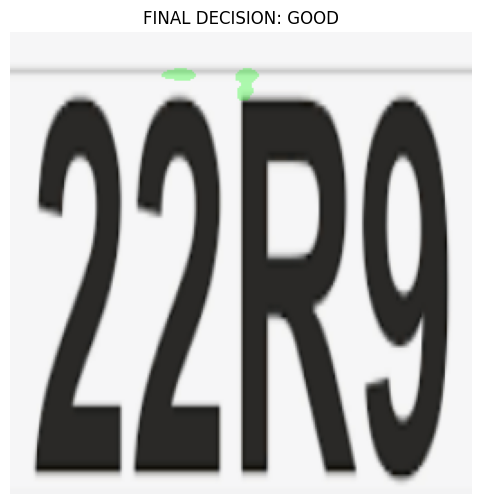


========== FINAL INFERENCE RESULT ==========
Image                  : /kaggle/input/real-world-data/Screenshot 2025-11-15 162812.png
Classifier Label       : GOOD
Classifier Conf (bad)  : 0.000000
Seg. Area Ratio        : 0.003906
Seg Decision (> 0.004484) : False
---------------------------------------------
FINAL DECISION         : GOOD



'good'

In [60]:
# -------------------------------
# Single Image Evaluation - One Image Output (Overlay Only)
# -------------------------------

import torch
import timm
import cv2
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

MODEL_CLS_PATH = "/kaggle/input/classification-and-segmentation/pytorch/default/1/efficientnet_b3_best.pt"
MODEL_SEG_PATH = "/kaggle/input/final-clafficatoin-and-segmentation-models/pytorch/default/1/u-net_final.pth"

IMG_SIZE_CLS = 224
IMG_SIZE_SEG = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

USER_THRESHOLD = 0.004484	
CLASSIFIER_CONF_THRESHOLD =0.551579

cls_tf = A.Compose([
    A.Resize(IMG_SIZE_CLS, IMG_SIZE_CLS),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

seg_tf = A.Compose([
    A.Resize(IMG_SIZE_SEG, IMG_SIZE_SEG),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# Load classifier
classifier = timm.create_model("efficientnet_b3", pretrained=False, num_classes=1)
classifier.load_state_dict(torch.load(MODEL_CLS_PATH, map_location=DEVICE))
classifier = classifier.to(DEVICE).eval()

# Load segmentation model
segmenter = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)
segmenter.load_state_dict(torch.load(MODEL_SEG_PATH, map_location=DEVICE))
segmenter = segmenter.to(DEVICE).eval()


def predict_classifier(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = cls_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        raw = classifier(x)
        prob_good = torch.sigmoid(raw).item()

    prob_bad = 1 - prob_good
    label = 1 if prob_bad >= CLASSIFIER_CONF_THRESHOLD else 0
    return label, prob_bad


def segment_scratches(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    t = seg_tf(image=img)
    x = t["image"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = torch.sigmoid(segmenter(x))

    mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    area_ratio = mask.sum() / mask.size

    img_vis = (t["image"].cpu().permute(1,2,0).numpy() *
               np.array([0.229,0.224,0.225]) +
               np.array([0.485,0.456,0.406]))
    img_vis = np.clip(img_vis * 255, 0, 255).astype(np.uint8)

    # Overlay mask in green
    overlay = img_vis.copy()
    overlay[mask == 1] = (0, 255, 0)
    vis = cv2.addWeighted(img_vis, 0.7, overlay, 0.3, 0)

    return mask, area_ratio, vis


def classify_single_image(image_path):

    cls_label, cls_conf = predict_classifier(image_path)
    mask, area_ratio, overlay = segment_scratches(image_path)

    seg_decision = area_ratio > USER_THRESHOLD

    # Hybrid logic
    if cls_label == 1 and seg_decision:
        final = 1
    elif cls_label == 1 and cls_conf < CLASSIFIER_CONF_THRESHOLD:
        final = 1
    elif cls_label == 1 and (not seg_decision) and cls_conf >= CLASSIFIER_CONF_THRESHOLD:
        final = 0
    elif cls_label == 0 and seg_decision:
        final = 1
    else:
        final = 0

    final_cls = "bad" if final == 1 else "good"

    # ---- SHOW ONLY ONE OUTPUT IMAGE ----
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"FINAL DECISION: {final_cls.upper()}")
    plt.show()

    # ---- PRINT RESULT ----
    print("\n========== FINAL INFERENCE RESULT ==========")
    print(f"Image                  : {image_path}")
    print(f"Classifier Label       : {'BAD' if cls_label==1 else 'GOOD'}")
    print(f"Classifier Conf (bad)  : {cls_conf:.6f}")
    print(f"Seg. Area Ratio        : {area_ratio:.6f}")
    print(f"Seg Decision (> {USER_THRESHOLD}) : {seg_decision}")
    print("---------------------------------------------")
    print(f"FINAL DECISION         : {final_cls.upper()}")
    print("=============================================\n")

    return final_cls


# ---------------- RUN TEST ----------------
test_image = "/kaggle/input/real-world-data/Screenshot 2025-11-15 162812.png"
classify_single_image(test_image)
